<a href="https://colab.research.google.com/github/epi2me-labs/tutorials/blob/master/Clone_validation_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Validation of cloned DNA material using Nanopore sequencing</h1>

The workflow below is intended to assess a molecular cloning experiment, specifically whether the introduction of one sequence into another has been successful. For example, the introduction of a protein encoding sequence into a plasmid vector molecule.

Questions answered by this tutorial include:

* If a barcoding strategy has been used, what fraction of demultiplexed reads
correspond to the target of interest.
* Does a sequenced DNA construct correspond to its expected sequence? 
* Does the sequenced DNA construct contain frameshifts or base substitions?
* If the DNA construct encodes a peptide sequence, is the peptide sequence correct?

Methods used in this tutorial include:

* `guppy_barcoder` for the demultiplexing of barcoded sequence reads,
* `mini_align` from the `pomoxis` package is used to align sequence reads to the target sequence of interest, and
* `flye` is used to assemble the input sequencing reads,

Computational requirements for this tutorial:

* A computer running the **EPI2ME Labs** server
* 16Gb RAM

> ⚠️ **Warning:** This notebook has been saved with its outputs for demostration purposed. It is recommeded to select `Edit > Clear all outputs` before using the notebook to analyse your own data.



## Introduction

This tutorial aims to determine the success of a molecular cloning experiment; to determine whether one DNA sequence has been correctly inserted into another as the experimentalist was expecting.

The goals from this tutorial include:

* Understand how to perform basic QC steps on the input data.
* Know how to assess the circularisation of a sequence assembly.
* Verify that the required sequence has been correctly inserted into the target.

This workflow naturally requires knowledge of the target sequence and optionally its encoded peptide. The methodology presented is based on an sequence assembly method; an alternative simpler method would be to employ simple sequence alignment.

## Getting started

The workflow below requires a single folder containing .fastq files from an Oxford Nanopore Technologies' sequencing device, or a single such file. Compressed or uncompressed files may be used. In addition a DNA reference sequences for the vector is required, and a protein reference sequence for the inserted DNA sequence.

Before anything else we will create and set a working directory:

In [ ]:
from epi2melabs import ping
tutorial_name = "clone_validation"
pinger = ping.Pingu()
pinger.send_notebook_ping('start', tutorial_name)

# create a work directory and move into it
working_dir = '/epi2melabs/{}/'.format(tutorial_name)
!mkdir -p "$working_dir"
%cd "$working_dir"

### Install additional software

This tutorial uses a couple of software packages that are not included in the default **EPI2ME Labs** server. Below we will install software packages that include `last` and `diamond` using the `conda` package manager. 

*Please note that the software installed is not persistent and this step will need to be re-run if you stop and restart the EPI2ME Labs server*

In [ ]:
!mamba install -y -q -c bioconda last diamond

### Sample Data

To demonstrate the workflow below a sample dataset is included with this tutorial. The dataset comprises data from a small Flongle sequencing experiment together with a vector DNA sequence and target gene protein sequence.

To download the sample file we run the `linux` command `wget`. To execute the command click on the cell and then press Command/Ctrl-Enter, or click the Play symbol to the left-hand side.

In [ ]:
bucket = "ont-exd-int-s3-euwst1-epi2me-labs"
domain = "s3-eu-west-1.amazonaws.com"
site = "https://{}.{}".format(bucket, domain)

!rm -rf clone_sample_data clone_sample_data.tar.gz
!wget -O clone_sample_data.tar.gz \
    "$site/$tutorial_name/clone_sample_data.tar.gz"
!tar -xzvf clone_sample_data.tar.gz

The dataset contains four files. One of these (`flone_clone_data.fastq.gz`) is a small set of single-molecule sequencing reads from a Flongle flowcell. The reads comprise five multiplexed samples. For two of these samples (barcodes 01 and 02) the dataset contains the target peptides: `peptide1.fasta` and `peptide2.fasta` respectively. These have been successfully incorporated into the vector sequence `vector.fasta`, as the workflow will show.

### Using your own data

If you have your own sequencing, you can edit the value of the input variables below in the **Data Entry** section. To find the correct full path of a file you can navigate to it in the **Files** browser to the left-hand side, right-click on the file and select **Copy path**:

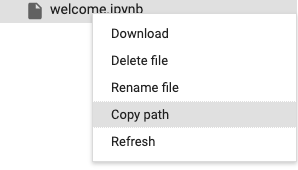

The location shared with the EPI2ME labs server from your computer will show as `/epi2melabs`, for example a file located at `/data/my_gridion_run/fastq_pass` on your computer will appear as `/epi2melabs/my_gridion_run/fastq_pass` when it is the `/data` folder that is shared.

### Data entry

Having downloaded the sample data, or locating your own data in the file browser, we need to provide the filepaths as input to the notebook.

The form can be used to enter the filenames of your inputs. Alternatively you can edit the code which reads the inputs by first double clicking the form header. After entering your inputs (or editing the code cell) remember to execute the code using `Command/Ctrl-Enter`, or pressing the `Play` symbol to the left-hand side.

>**This workflow requires has some manual intervention steps to check the sanity of intermediate outputs. It is not recommended to use the `Run All` functionality.**

In [40]:
#@markdown Enter the path to your input files (*click **here** to view code*)

#@markdown The `input_reads` item may be a single folder containing .fastq files from an Oxford Nanopore Technologies' sequencing device, or a single such file. 
import os

import pandas as pd
import pysam

import aplanat
from aplanat.graphics import InfoGraphItems
from aplanat.report import HTMLReport

# set variables for our inputs
input_reads = 'clone_sample_data/flongle_clone_data.fastq.gz'  #@param {type: "string"}
output_folder = 'analysis'  #@param {type: "string"}
target_dna_sequence = 'clone_sample_data/vector.fasta' #@param {type: "string"}
target_peptide = 'clone_sample_data/peptide1.fasta' #@param {type: "string"}
threads = 8 #@param {type: "integer"}
demultiplex = True #@param {type: "boolean"}
samples_analysed = dict()

all_good = True
!cecho ok "Checking read inputs..."
fail_msg = "The input read file is not a valid file or folder."
if os.path.isdir(input_reads):
    print(" - Found input folder.")
elif os.path.isfile(input_reads):
    print(" - Found input file, moving to a folder")
    # guppy demultiplexer takes only an input folder
    fname = os.path.basename(input_reads)
    !mkdir -p reads \
        && mv $input_reads reads
    input_reads = os.path.abspath("reads")
elif os.path.isdir('reads'):
    moved_file = os.path.join('reads', os.path.basename(input_reads))
    if os.path.isfile(moved_file):
        input_reads = os.path.abspath("reads")
        print(" - Found previously moved file.")
    else:
        !cecho error "$fail_msg"
        all_good = False
else:
    !cecho error "$fail_msg"
    all_good = False
print(" - Input reads is: {}.".format(input_reads))

!cecho ok "Making output folder..."
!mkdir -p output_folder

!cecho ok "Checking reference inputs..."
if not os.path.isfile(target_dna_sequence):
    !cecho error "Target sequence file does not exist."
    all_good = False
else:
    with pysam.FastaFile(target_dna_sequence) as fh:
        if fh.nreferences != 1 or fh.lengths[0] < 1:
            !cecho error " - $target_dna_sequence does not contain a single sequence."
            all_good = False
        else:
            print(" - Found sequence (target): {}".format(fh.references[0]))
if not os.path.isfile(target_peptide):
    !cecho error "Target peptide file does not exist."
    all_good = False
else:
    with pysam.FastaFile(target_peptide) as fh:
        if fh.nreferences != 1 or fh.lengths[0] < 1:
            !cecho error " - $target_peptide does not contain a single sequence."
            all_good = False
        else:
            print(" - Found sequence (peptide): {}".format(fh.references[0]))

if all_good:
    !cecho success "Inputs validated."
else:
    !cecho error "One or more errors detected while checking inputs."

report = HTMLReport(
    "Nanopore Clone Validation workflow", "EPI2ME Labs Summary",
    require_keys=True)
report.markdown('### Experiment Summary', 'exp-summ-head')
report.placeholder(key='exec-plot')  # placeholder
exec_summary = InfoGraphItems()


Checking read inputs...
 - Found previously moved file.
 - Input reads is: /epi2melabs/clone_validation/reads.
Making output folder...
Checking reference inputs...
 - Found sequence (target): vector
 - Found sequence (peptide): peptide1
Inputs validated.


With our workspace prepared we will now move on to the analysis of our data.

### Preliminary Analysis Section

It is likely that multiple DNA constructs will have been barcoded and run in parallel during a sequencing run. For this reason we include an optional barcode **demultiplexing** step in this workflow.

> After demultiplexing, this notebook is concerned with only a single sample. To analyse all samples the later sections of this notebook will need to be run sequentially. The results of analysing each of the samples will be accumulated into a report which can be downloaded at the end of the notebook.

If a barcoding strategy has not been used within your experiment, this step can be skipped.

In [7]:
#@markdown **Running Guppy demultiplexing** *(press play)*
barcode_kit = "SQK-RBK004" #@param {type: "string"}

!rm -rf $output_folder/demultiplex
if demultiplex:
    !guppy_barcoder \
        --barcode_kits $barcode_kit \
        --compress_fastq --records_per_fastq 0 --recursive --worker_threads $threads \
        --save_path $output_folder/demultiplex \
        --input_path $input_reads \
        && cecho success "Guppy finished successfully" \
        || cecho error "Guppy failed"
else:
    print("Skipping demultiplexing as requested.")



ONT Guppy barcoding software version 3.5.2+5b7a51b
input path:         /epi2melabs/clone_validation/reads
save path:          analysis/demultiplex
arrangement files:  barcode_arrs_rbk4.cfg 
min. score front:   60
min. score rear:    60


Found 1 fastq files.

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Done in 535 ms.
Guppy finished successfully


Having run demultiplexing of reads below code cell will allow you to view the number of reads found to contain each barcode and allow you to select which group of reads to use in the remainder of the workflow. If you have not run demultiplexing the code will set parameters for the workflow. *It is necessary to run this step even in the case of a single (unbarcoded) analyte.*

In [8]:
#@markdown **Review demultiplex barcode assignments** *(click to show)*

import ipywidgets as widgets
from IPython.display import display

import aplanat
from aplanat import bars, hist, annot
from bokeh.models import Span
from bokeh.layouts import gridplot

minimum_reads = 150
read_source = None
complete_fastq = None
dataset_name = None
dataset_folder = None

barcodes_found = 'NA'

if not demultiplex:
    read_source = input_reads
    dataset_name = 'all_data'
    dataset_folder = os.path.join(output_folder, dataset_name)
    complete_fastq = os.path.join(dataset_folder, "all_data.fastq")
    barcodes_found = 'NA'
else:
    barcode_summary_file = os.path.join(
        output_folder, "demultiplex", "barcoding_summary.txt")
    if not os.path.exists(barcode_summary_file):
        print("Could not find barcode summary: {}.".format(barcode_summary_file))
    else:
        try:
            bc_summary = pd.read_csv(barcode_summary_file, sep='\t')
        except Exception as e:
            print("Could not read barcode summary: {}".format(barcode_summary))
    
    # barcode count plot
    barcode_counts = pd.DataFrame(bc_summary['barcode_arrangement'].value_counts()) \
        .sort_index().reset_index().rename(
            columns={'index':'barcode', 'barcode_arrangement':'count'})
    bc_counts = bars.simple_bar(
        barcode_counts['barcode'], barcode_counts['count'],
        title='Number of reads per barcode')
    bc_counts = annot.subtitle(
        bc_counts,
        '>{} reads are recommended for further analysis.'.format(
            minimum_reads))
    bc_counts.xaxis.major_label_orientation = 3.14 / 4
    bc_counts = annot.marker_hline(bc_counts, minimum_reads)
    aplanat.show(bc_counts)
    report.plot(bc_counts, key='bc-plot')

    barcode_counts['sufficient data'] = barcode_counts['count'] > minimum_reads
    valid_barcodes = set(
        barcode_counts.loc[barcode_counts['sufficient data']]['barcode'])
    barcodes_found = len(valid_barcodes)
    valid_barcodes.discard("unclassified")
    valid_barcodes = sorted(valid_barcodes)

    def barcode_change(change):
        global dataset_name
        global dataset_folder
        global read_source
        global complete_fastq
        if change['type'] == 'change' and change['name'] == 'value':
            dataset_name = change['new']
            dataset_folder = os.path.join(output_folder, dataset_name)
            read_source = os.path.join(
                output_folder, "demultiplex", dataset_name)
            complete_fastq = os.path.join(dataset_folder, "{}.fastq".format(dataset_name))

    barcode_dropdown = widgets.Dropdown(
        options=valid_barcodes, value=dataset_name, description='Barcode:')
    barcode_dropdown.observe(barcode_change)
    print("Select a barcode to use for the remainder")
    display(barcode_dropdown)
exec_summary.append('Barcodes found', str(barcodes_found), 'balance-scale')

Select a barcode to use for the remainder


Dropdown(description='Barcode:', options=('barcode01', 'barcode02', 'barcode03', 'barcode04', 'barcode05'), va…


Our choice of barcode has been made. Let us quickly review the quality and size distribution of the associated sequences:


In [9]:
#@markdown **FASTQ assessment** *(click to show)*
from aplanat.hist import histogram
from bokeh.layouts import gridplot
import numpy as np
from pysam import FastxFile

if read_source is None or complete_fastq is None:
    raise RuntimeError("Please run the previous code cell.")

!mkdir -p $dataset_folder
!rationalise_fastq -i $read_source -o $complete_fastq

mean_qualities = list()
lengths = list()

# open the file and iterate through its records
with FastxFile(complete_fastq) as fq:
    for rec in fq:
        # ONT calculation for "mean Q score"
        quals = np.fromiter(
            (ord(x) - 33 for x in rec.quality),
            dtype=int, count=len(rec.quality))
        mean_p = np.mean(np.power(10, quals/-10))
        mean_qualities.append(-10*np.log10(mean_p))
        lengths.append(len(quals))

p1 = histogram(
    [np.array(mean_qualities)], title="Read quality scores",
    x_axis_label="quality", y_axis_label="count",
    height=250, width=300)
p2 = histogram(
    [lengths], title="Read lengths",
    x_axis_label="read length / bases", y_axis_label="count",
    height=250, width=300, bins=100, xlim=(0, 7000))
stats_plots = gridplot((p1, p2), ncols=2)
aplanat.show(stats_plots)

# Setup report for barcode 
section = report.add_section(dataset_name)
bc_summary = InfoGraphItems()
bc_summary.extend((
    ('Median read length', str(int(np.median(lengths))), 'align-center', 'b'),
    ('Median read quality', str(int(np.median(mean_qualities))), 'thumbs-up', '')))
section.markdown(
    "### {} Analysis".format(dataset_name.capitalize()),
    key='{}-heading'.format(dataset_name))
section.placeholder('exec-plot')
section.plot(stats_plots, key='statsplots')

Input: /epi2melabs/clone_validation/analysis/demultiplex/barcode01
Output: /epi2melabs/clone_validation/analysis/barcode01/barcode01.fastq
Directory detected, concatenating found files.
Found 1 files.
Concatenating files...done.


## Analysis of a single barcoded analyte

In the sections above we have prepared our single-molecule sequence reads for further examination. The remainder of this notebook deals with the assembly of these reads and comparison of the assembly to the reference sequences provided.

Use the form below to select a set of parameters for the filtering and downsampling of the sequence collection. The code block will filter the available `.fastq` sequences using `seqkit`, and then further downsample (also using `seqkit`) to produce a dataset of approximately the fold-coverage requested.

In [10]:
#@markdown **Click the play button** to initialise these values and
#@markdown filter the sequence collection.

shortest_read = 4000  #@param {type: "integer"}
longest_read = 5000  #@param {type: "integer"}
quality_filter =  13#@param {type: "integer"}

expected_size = 4700 #@param {type: "integer"}
assemble_x = 150 #@param {type: "integer"}

#@markdown Select the fastq source data to use subsequently

dataset = 'sampled' #@param ["complete", "filtered", "sampled"]

print("Calculating stats. for complete dataset...")
!seqkit stats --tabular "$complete_fastq" > "$complete_fastq".stats
complete_stats = pd.read_csv("{}.stats".format(complete_fastq), delimiter='\t')

print("Filtering dataset by length and quality...")
filtered_fastq = complete_fastq.replace('.fastq', '.filtered.fastq')
!seqkit seq --remove-gaps --min-len "$shortest_read" --max-len "$longest_read" \
    --min-qual "$quality_filter" "$complete_fastq" > "$filtered_fastq"
!seqkit stats --tabular "$filtered_fastq" > "$filtered_fastq".stats
filtered_stats = pd.read_csv("{}.stats".format(filtered_fastq), delimiter='\t')

print("Subsampling filtered dataset...")
needed_bases = expected_size * assemble_x
reqd_reads = int((expected_size * assemble_x) // filtered_stats['avg_len'][0])
print("Require {} bases ({} total), approximately {} reads".format(
    needed_bases, filtered_stats['sum_len'][0], reqd_reads))

sampled_fastq = filtered_fastq.replace(
    '.filtered.fastq', '.filtered.sampled.fastq')
!seqkit sample --quiet -n "$reqd_reads" --two-pass "$filtered_fastq" > "$sampled_fastq" 
!seqkit stats --tabular $sampled_fastq > "$sampled_fastq".stats
sampled_stats = pd.read_csv("{}.stats".format(sampled_fastq), delimiter='\t')

display_stats = pd.concat(
    (complete_stats, filtered_stats, sampled_stats)).reset_index(drop=True)
display_stats['file'] = display_stats['file'].apply(os.path.basename)
display(display_stats)
section = report.sections[dataset_name]
section.markdown(
    "The table below details read counts and lengths after filtering.",
    key="countlead".format(dataset_name))
section.table(display_stats, key='read-stats')

fastqs = dict(zip(
    ('complete', 'filtered', 'sampled'),
    ((complete_fastq, complete_stats),
     (filtered_fastq, filtered_stats),
     (sampled_fastq, sampled_stats))))
fastq_source, stats_source = fastqs[dataset]
data_prefix = os.path.splitext(fastq_source)[0]
ave_length = int(stats_source['avg_len'][0])
print("Selecting `{}` for onward use, with average read length {}.".format(
    fastq_source, ave_length))
bc_summary.append('Reads used', str(int(stats_source['num_seqs'][0])), 'bookmark')

Calculating stats. for complete dataset...
Filtering dataset by length and quality...
Subsampling filtered dataset...
Require 705000 bases (904008 total), approximately 148 reads


,file,format,type,num_seqs,sum_len,min_len,avg_len,max_len
0,barcode01.fastq,FASTQ,DNA,563,1919056,158,3408.6,13659
1,barcode01.filtered.fastq,FASTQ,DNA,191,904008,4035,4733.0,4792
2,barcode01.filtered.sampled.fastq,FASTQ,DNA,148,700544,4035,4733.4,4792


Selecting `analysis/barcode01/barcode01.filtered.sampled.fastq` for onward use, with average read length 4733.


At this point we have selected, filtered, and optionally downsampled our sequencing reads. To check we have a reasonable volume and quality of data to perform the assembly step we will align the reads to the vector reference given at the start of the workflow.


In [11]:
# run alignments
!rm -f "$data_prefix".bam*
!mini_align \
    -r "$target_dna_sequence" -i "$fastq_source" \
    -p "$data_prefix" \
    -t 4
# calculate read stats
!stats_from_bam "$data_prefix".bam > "$data_prefix".bam.stats
# calculate depth
!mosdepth -t 2 --flag 1812 "$data_prefix".fwd "$data_prefix".bam 
!mosdepth -t 2 --flag 1796 --include-flag 16 "$data_prefix".rev "$data_prefix".bam

Constructing minimap index.
[M::mm_idx_gen::0.003*1.95] collected minimizers
[M::mm_idx_gen::0.006*2.46] sorted minimizers
[M::main::0.011*1.84] loaded/built the index for 1 target sequence(s)
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.011*1.83] distinct minimizers: 676 (99.85% are singletons); average occurrences: 1.001; average spacing: 5.402
[M::main] Version: 2.17-r941
[M::main] CMD: minimap2 -I 16G -x map-ont -d clone_sample_data/vector.fasta.mmi clone_sample_data/vector.fasta
[M::main] Real time: 0.012 sec; CPU: 0.021 sec; Peak RSS: 0.003 GB
[M::main::0.006*1.40] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.006*1.38] mid_occ = 3
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.006*1.36] distinct minimizers: 676 (99.85% are singletons); average occurrences: 1.001; average spacing: 5.402
[M::worker_pipeline::0.082*2.85] mapped 148 sequences
[M::main] Version: 2.17-r941
[M::main] CMD: mini

Two helpful visualizations of these alignment results are the depth of sequencing across the reference and the accuracy of the reads with respect to the reference.

> In this experiment we are expecting differences from the reference sequence to occur in our reads, so the accuracy of the reads may appear lower than otherwise expected. The plots also report only a single, primary, alignment of reads: if the read length is a significant fraction of the plasmid size coverage may appear reduced at the edges of the reference and read coverage may be low. This is expected and normal.

In [12]:
#@markdown **Alignment visualization code** *(click to show)*
from aplanat import annot, lines, hist, util
from bokeh.layouts import gridplot

depth_fwd = pd.read_csv(
    '{}.fwd.per-base.bed.gz'.format(data_prefix), sep='\t',
    names=['ref', 'start', 'end', 'depth'])
depth_rev = pd.read_csv(
    '{}.rev.per-base.bed.gz'.format(data_prefix), sep='\t',
    names=['ref', 'start', 'end', 'depth'])
depth_plot = lines.steps(
    [depth_fwd['start'], depth_rev['start']],
    [depth_fwd['depth'], depth_rev['depth']],
    colors=['darkolivegreen', 'maroon'],
    names=['Forward', 'Reverse'],
    x_axis_label='Position along reference',
    y_axis_label='sequencing depth / bases')
stats = pd.read_csv("{}.bam.stats".format(data_prefix), sep='\t')

x_grid, pdf = util.kernel_density_estimate(stats['acc'])
mode = x_grid[np.argmax(pdf)]
acc_plot = lines.line(
    [x_grid], [pdf],
    x_axis_label="read accuracy", y_axis_label="read density")
acc_plot = annot.marker_vline(acc_plot, mode, label='mode: {:.1f}'.format(mode))

x_grid, pdf = util.kernel_density_estimate(stats['coverage'])
mode = x_grid[np.argmax(pdf)]
cover_plot = lines.line(
    [x_grid], [pdf],
    x_axis_label="read coverage", y_axis_label="read density")
cover_plot = annot.marker_vline(cover_plot, mode, label='mode: {:.1f}'.format(mode))

plot = gridplot([acc_plot, cover_plot, depth_plot], ncols=2)
aplanat.show(plot)
section = report.sections[dataset_name]
section.markdown(
    "Read metrics with respect to the provided reference are shown below. "
    "The read coverage is expected to be low for reads of a similar length "
    "to the reference size. Similarly the coverage graph may show a large "
    "bias toward the middle of the sequence.",
    key="countlead".format(dataset_name))
section.plot(plot, key='read-plots')


Provided these plots look reasonable, containing the target coverage across the genome and read accuracy > 93%, we can proceed to the next assembly section of the workflow. If the coverage is low try altering the filtering and sampling settings above.

### De novo assembly of the plasmid sequence

It is now time to create an assembly from our selected read data. To do this we will use the `flye` assembler. Flye is a versatile and moderately fast assembler which provides good results in most situations with little parameterisation:

In [13]:
#@markdown **Run flye assembly of selected data** *(click to show)*

#@markdown The minumum overlap fraction is multiplied by the average read length
#@markdown to determine the minimum read overlap size used within the assembly.
overlap_fraction = 0.5 #@param {type:"number"}

assembly_out = os.path.join(dataset_folder, "flye")
min_overlap = int(overlap_fraction * min(expected_size, ave_length))
!rm -rf $assembly_out
!mkdir -p "$assembly_out"
!flye --out-dir $assembly_out --nano-raw $fastq_source \
    --genome-size $expected_size --meta --threads $threads \
    --min-overlap $min_overlap

[2020-08-24 09:06:46] INFO: Starting Flye 2.7.1-b1590
[2020-08-24 09:06:46] INFO: >>>STAGE: configure
[2020-08-24 09:06:46] INFO: Configuring run
[2020-08-24 09:06:46] INFO: Total read length: 700544
[2020-08-24 09:06:46] INFO: Input genome size: 4700
[2020-08-24 09:06:46] INFO: Estimated coverage: 149
[2020-08-24 09:06:46] INFO: Reads N50/N90: 4740 / 4711
[2020-08-24 09:06:46] INFO: Selected minimum overlap: 2350
[2020-08-24 09:06:46] INFO: Selected k-mer size: 15
[2020-08-24 09:06:46] INFO: >>>STAGE: assembly
[2020-08-24 09:06:46] INFO: Assembling disjointigs
[2020-08-24 09:06:46] INFO: Reading sequences
[2020-08-24 09:06:46] INFO: Generating solid k-mer index
[2020-08-24 09:07:00] INFO: Counting k-mers (1/2):
0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100% 
[2020-08-24 09:07:00] INFO: Counting k-mers (2/2):
0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100% 
[2020-08-24 09:07:00] INFO: Filling index table (1/2)
0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100% 
[2020-08-24 09:07:00] INFO: Filling in

When `flye` has finished running it will have output something similar to:

```
	Total length:   9997
	Fragments:      1
	Fragments N50:  9997
	Largest frg:    9997
	Scaffolds:      0
	Mean coverage:  63
```

If this is not the case return to the data filtering section above.

The statistics above summarise a file output by `flye` which can be inspected by running:

In [14]:
assembly = os.path.join(assembly_out, "assembly.fasta")
flye_info = pd.read_csv(os.path.join(assembly_out, "assembly_info.txt"), delimiter='\t')
display(flye_info)
section = report.sections[dataset_name]
section.markdown('Summary of initial assembly:', key='assm-stats-head')
section.table(flye_info, index=False, key='assm-stats')

,#seq_name,length,cov.,circ.,repeat,mult.,alt_group,graph_path
0,contig_1,9351,85,Y,N,1,*,1


We expect to see a single long contig; the length of this may well be larger than the expected length and similar to whole number multiples of the expected length. If this is so try to run the assembly again with a larger value of the overlap fraction. If you obtain more than a single contig try altering the parameter until only one is obtained.

In the table, the contig will likely be identified as circular. A circular contig from the *de novo* assembly of a plasmid will likely contain duplicated sequences at the end of the sequence. Let's check if this is the case by preparing a dotplot showing regions of similarity when the assembly is compared to itself:

In [15]:
#@markdown **Creating a dotplot** *(click to show)*
import tempfile
from aplanat import base
assm_dir = os.path.join(output_folder, "assm_check")
assm2assm = os.path.join(assm_dir, "aln.paf")
!mkdir -p $assm_dir

def last_dot(fasta, ref=None):
    tmp = tempfile.mkdtemp()
    if ref is None:
        ref = fasta
    !lastdb $tmp/lastdb $ref
    !lastal $tmp/lastdb $fasta > $tmp/alns.maf
    records = list()
    with open(os.path.join(tmp, "alns.maf")) as maf:
        while True:
            line = maf.readline()
            if line.startswith('#'):
                continue
            elif line.startswith('a'):
                r1 = maf.readline().split()[1:5]
                r2 = maf.readline().split()[1:5]
                blank = maf.readline()
                records.append(r1 + r2)
            elif line == "":
                break
            else:
                print(line)
                raise IOError("Cannot read alignment file")
    names = ['ref', 'rstart', 'rlen', 'rorient', 'query', 'qstart', 'qlen', 'qorient']
    df = pd.DataFrame(records, columns=names)
    df = df.loc[df['qorient'] == '+']
    for f in ['qstart', 'qlen', 'rstart', 'rlen']:
        df[f] = df[f].astype(int)
    df['qend'] = df['qstart'] + df['qlen']
    df['rend'] = df['rstart'] + df['rlen']
    !rm -rf $tmp
    return df

df = last_dot(assembly)    
dotplot = base.simple(
    [], [], xlim=(0, max(df['rend'])), ylim=(0, max(df['qend'])),
    width=440, height=400, x_axis_label='position', y_axis_label='position')
dotplot.segment(df['rstart'], df['qstart'], df['rend'], df['qend'])
aplanat.show(dotplot)

We would like to obtain a single coherent, linearised sequence repesenting the circular biological molecule. To do this we can break the contig in half and put it back together removing the duplicated sequence. This is done in the following code cell.

In [16]:
#@markdown **Circularising assembly by overlap-based trimming** *(click to show)*
from aplanat.report import bokeh_table
import pysam

def split_and_align(sequence_in, name):

    print("Aligning two halves of assembly...")
    with pysam.FastaFile(sequence_in) as fasta:
        if len(fasta.references) > 1:
            raise IOError("More than one contig found in assembly.")
        rec = fasta.fetch(fasta.references[0])
        half = len(rec) // 2
        first, second = rec[0:half], rec[half:]
        lengths = [len(x) for x in (first, second)]
    
    split_assm = os.path.join(assm_dir, 'split.{}.fasta')
    paf = os.path.join(assm_dir, 'overlap.paf')
    for name, seq in enumerate((first, second)):
        with open(split_assm.format(name), 'w') as fh:
            fh.write(">seq{}\n{}\n".format(name, seq))
    s0, s1 = (split_assm.format(x) for x in range(2))
    !minimap2 -cx asm5 $s0 $s1 > $paf 2> /dev/null
    return paf, first, second

# flye can give lots of repeats, find overlaps and trime iteratively
finished = False
iteration = 0
trimmed_assm = assembly
plots = list()
while not finished:
    iteration += 1
    print("Iteration: {}".format(iteration))
    print(" - Trimming sequence according to overlap...")
    paf, first, second = split_and_align(trimmed_assm, 'iter_{}'.format(iteration))
    try:
        df = pd.read_csv(paf, sep='\t', header=None)
    except ValueError:
        print(" - No alignments found, leaving assembly untrimmed.")
        finished = True
    else:
        if len(df) != 1:
            print(" - Found multiple alignments, selecting best.")
            df = df[df[2] < 5]
            if len(df) == 0:
                print("- Could not find suitable alignment, leaving assembly untrimmed.")
                finished = True
        else:
            finished = True
        start1, end1 = df[2][0], df[3][0]
        start0, end0 = df[7][0], df[8][0]
        new_seq = second[:end1] + first[end0:]
        trimmed_assm = assembly.replace(".fasta", ".trimmed.fasta")
        print(" - Writing trimmed sequence to {}.".format(trimmed_assm))
        with open(trimmed_assm, 'w') as fh:
            fh.write(">contig_trim\n{}\n".format(new_seq))
        print("Redoing dotplot...")
        df = last_dot(trimmed_assm)
        dotplot = base.simple(
            [], [], xlim=(0, max(df['rend'])), ylim=(0, max(df['qend'])),
            width=440, height=400, title='After trim iteration {}'.format(iteration),
            x_axis_label='position', y_axis_label='position')
        dotplot.segment(df['rstart'], df['qstart'], df['rend'], df['qend'])
        plots.append(dotplot)
        plots.append(bokeh_table(df, index=False))

aplanat.show(gridplot(plots, ncols=2))

Iteration: 1
 - Trimming sequence according to overlap...
Aligning two halves of assembly...
 - Writing trimmed sequence to analysis/barcode01/flye/assembly.trimmed.fasta.
Redoing dotplot...


The result of the above should be a single alignment with no off-diagonal elements. If this is not the case try to amend the assembly parameters. If a single diagonal alignment is not obtainable automatically, it may be possible to examine the alignment co-ordinates and dot plots to manually determine how to edit the sequence.

In [ ]:
#@markdown **Manual edit of assembly**
from Bio import SeqIO
perform_edit = False #@param {type:"boolean"}
start_position = 0 #@param {type:"integer"}
end_position =  4539#@param {type:"integer"}

if perform_edit:
    if start_position == end_position:
        print("Start and end positions should not be equal.")
    else:
        fasta = SeqIO.read(trimmed_assm, "fasta")
        manual_assm = assembly.replace(".fasta", ".manualtrim.fasta")
        edited = fasta[start_position:end_position]
        SeqIO.write(edited, manual_assm, "fasta")
        trimmed_assm = manual_assm




In this section we have assembled our single-molecule reads into a single contiguous sequence. With a few simple algorithms and manual inspection we have ensured that this contig sequence contains no repetivitive sequence due to the originating target molecule being circular. In the next sections we will improve the quality of the contig and analyse it to determine if it contains the peptide of interest.

### Medaka polishing of assembly

With our assembly tidied up to remove duplicate sequence, the base-level quality of the assembly can be improved by using medaka:

In [17]:
#@markdown **Running medaka to polish assembly** *(click to show)*
from Bio import SeqIO
medaka_dir = os.path.join(dataset_folder, "medaka")
medaka_consensus = os.path.join(medaka_dir, "consensus.fasta")
!rm -rf $medaka_dir
!mkdir -p $medaka_dir/
!mini_assemble -t $threads -i $fastq_source -r $trimmed_assm -o $medaka_dir/racon/ -p assm 2>/dev/null 
!run medaka_consensus -i $fastq_source -d $trimmed_assm -o $medaka_dir
medaka_seq = SeqIO.read(medaka_consensus, "fasta")
text = "The final assembly after medaka correction contains {} bases".format(len(medaka_seq))
bc_summary.append("Assembly length", str(len(medaka_seq)), 'ruler', 'b')
print(text)
section = report.sections[dataset_name]
section.markdown(text, "medaka-length")

Copying FASTX input to workspace: analysis/barcode01/barcode01.filtered.sampled.fastq > analysis/barcode01/medaka/racon//assm.fa.gz
Skipped adapter trimming.
Skipped pre-assembly correction.
Using supplied reference to perform reference-guided consensus.
Running racon read shuffle 1...
Running round 1 consensus...
Running round 2 consensus...
Running round 3 consensus...
Running round 4 consensus...
Waiting for cleanup.
Final assembly written to analysis/barcode01/medaka/racon//assm_final.fa. Have a nice day.
Checking program versions
This is medaka 1.0.3
Program    Version    Required   Pass     
bcftools   1.10.2     1.9        True     
bgzip      1.10.2     1.9        True     
minimap2   2.17       2.11       True     
samtools   1.10       1.9        True     
tabix      1.10.2     1.9        True     
Aligning basecalls to draft
Removing previous index file /epi2melabs/clone_validation/analysis/barcode01/flye/assembly.trimmed.fasta.mmi
Removing previous index file /epi2melabs/cl

### Rotating assembly to reference and identifying target peptide

In the previous section we first assembled our reads to obtain a single contiguous sequence. This sequence was trimmed to remove duplicated sequence under the assumption that the sequenced molecule is circular. We then improved the base-level quality of the trimmed sequence using `medaka`.

In this section we will now compare the assembly to the supplied reference sequences. In order to make this comparison easier we will first attempt to rotate the assembly so that its start co-ordinate matches that of the reference sequence.

When the sequence coordinates have been corrected, the BLAST results between the reference and assembled plasmids will be shown. Please assess the sequence alignments for expected coordinates.


In [18]:
#@markdown **Synchronising assembled plasmid and reference plasmid** *(click to show)*

#@markdown Set a tolerance for determining as sequence match lies at the start of the reference:
start_tolerance =  20#@param {type:'integer'}

from Bio import SearchIO, SeqIO
corrected_sequence = medaka_consensus
curation_folder = os.path.join(dataset_folder, "curation")
curated_sequence = os.path.join(curation_folder, "assembly.fasta")

blast_db = os.path.join(
    curation_folder, "{}.blastdb".format(os.path.basename(target_dna_sequence)))
blast_result = blast_db.replace(".blastdb", "blastxml")
!makeblastdb -in $target_dna_sequence -dbtype nucl -out $blast_db
!blastn -db $blast_db -query $medaka_consensus -outfmt 5 -out $blast_result

blast_parse = SearchIO.read(blast_result, 'blast-xml')
if len(blast_parse) > 0:
    qresult = blast_parse[0]
    if qresult[0].hit_frame < 0:
        print("Aligned sequence on the reverse strand - reverse complementing")
        corrected_sequence = os.path.join(medaka_dir, "consensus_rev_comp.fasta")
        !seqkit seq -p -r -t DNA -v $medaka_consensus > $corrected_sequence
        !blastn -db $blast_db -query $corrected_sequence -outfmt 5 -out $blast_result
else:
    print("No blast results")

blast_parse = SearchIO.read(blast_result, 'blast-xml')
if len(blast_parse) > 0:
    qresult = blast_parse[0]
    qres = sorted(qresult, key=lambda x: x.hit_start)
    hsp = qres[0]
    if hsp.hit_start <= start_tolerance:
        cut_pos = hsp.query_start
        print(
            "Cutting consensus at {}. Ref. position {}.".format(
                cut_pos, hsp.hit_start))
        fasta = SeqIO.read(corrected_sequence, "fasta")
        # write the new fasta sequence
        edited = fasta[cut_pos:] + fasta[:cut_pos]
        SeqIO.write(edited, curated_sequence, "fasta")
    else:
        print(
            "Could not find a valid match. The closest match to the "
            "start was at position {}. The sequence will be left " 
            "unchanged".format(hsp.hit_start))
        curated_sequence = corrected_sequence
        !cp $corrected_sequence $curated_sequence
else:
    curated_sequence = corrected_sequence
    !cp $corrected_sequence $curated_sequence

print("\nFinal curated sequence: {}.".format(curated_sequence))
print("Creating dotplot with rotated assembly against reference...")
df = last_dot(curated_sequence, ref=target_dna_sequence)
dotplot = base.simple(
    [], [], xlim=(0, max(df['rend'])), ylim=(0, max(df['qend'])),
    width=440, height=400, x_axis_label='ref position', y_axis_label='query position')
dotplot.segment(df['rstart'], df['qstart'], df['rend'], df['qend'])
aplanat.show(dotplot)



Building a new DB, current time: 08/24/2020 09:08:29
New DB name:   /epi2melabs/clone_validation/analysis/barcode01/curation/vector.fasta.blastdb
New DB title:  clone_sample_data/vector.fasta
Sequence type: Nucleotide
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 1 sequences in 0.00658607 seconds.
Cutting consensus at 791. Ref. position 13.

Final curated sequence: analysis/barcode01/curation/assembly.fasta.
Creating dotplot with rotated assembly against reference...


As a final sanity check we will align all sequencing reads to our final curated assembly to show the sequencing depth:

In [19]:
#@markdown **Alignment of reads to assembly** *(click to show)*

eval_path = os.path.join(dataset_folder, 'align_eval')
prefix = os.path.join(eval_path, 'reads2assm')
!rm -rf $eval_path
!mkdir -p $eval_path
# double sequence
doubled_seq = os.path.join(eval_path, "doubled.fasta")
seq = SeqIO.read(curated_sequence, "fasta")
half_len = len(seq) // 2
edited = seq[half_len:] + seq + seq[:half_len]
SeqIO.write(edited, doubled_seq, "fasta")
# align
print("Aligning reads...", end='')
!mini_align \
    -r "$doubled_seq" -i "$complete_fastq" \
    -p "$prefix" \
    -t 4 2> /dev/null
print("done.")
# calculate read stats
!stats_from_bam "$prefix".bam > "$prefix".bam.stats 2>/dev/null
# calculate depth
!mosdepth -t 2 --flag 1812 "$prefix".fwd "$prefix".bam 
!mosdepth -t 2 --flag 1796 --include-flag 16 "$prefix".rev "$prefix".bam

def unroll_depth(df, size):
    hsize = size // 2
    start = df['start'] < hsize
    mid = (df['start'] >= hsize) & (df['start'] < hsize + size)
    end = df['start'] >= size + hsize
    for item in ('start', 'end'):
        df.loc[start, item] += hsize
        df.loc[mid, item] -= hsize
        df.loc[end, item] -= size + hsize
    result = np.zeros(size, dtype=[('pos', int), ('depth', int)])
    result['pos'] = np.arange(size)
    for _, row in df.iterrows():
        result['depth'][row['start']:row['end']] += row['depth']
    return result

fwd = pd.read_csv(
    '{}.fwd.per-base.bed.gz'.format(prefix), sep='\t',
    names=['ref', 'start', 'end', 'depth'])
depth_fwd = unroll_depth(fwd, len(seq))
rev = pd.read_csv(
    '{}.rev.per-base.bed.gz'.format(prefix), sep='\t',
    names=['ref', 'start', 'end', 'depth'])
depth_rev = unroll_depth(rev, len(seq))

depth_plot = lines.steps(
    [depth_fwd['pos'], depth_rev['pos']],
    [depth_fwd['depth'], depth_rev['depth']],
    colors=['darkolivegreen', 'maroon'],
    names=['Forward', 'Reverse'],
    x_axis_label='Position along reference',
    y_axis_label='sequencing depth / bases',
    title='All reads aligned to circularise assembly')
stats = pd.read_csv("{}.bam.stats".format(prefix), sep='\t')

x_grid, pdf = util.kernel_density_estimate(stats['coverage'])
mode = x_grid[np.argmax(pdf)]
cover_plot = lines.line(
    [x_grid], [pdf],
    x_axis_label="read coverage", y_axis_label="read density",
    title='Alignment read coverage against circularised assembly',
    xlim=(90,100))
cover_plot = annot.marker_vline(cover_plot, mode, label='mode: {:.1f}'.format(mode))

plot = gridplot([cover_plot, depth_plot], ncols=2)
aplanat.show(plot)
section.plot(plot, key='assm-eval')

Aligning reads...done.


The final step of our analysis is to identify the target peptide in our assembly to check that it is present and correct. To do this we will used `diamond` to align the peptide sequence given at the start of the analysis to the translated assembly sequence:


In [20]:
#@markdown **Identifying target peptide in assembly** *(click to show)*
from aplanat.graphics import infographic
print("Assembly: {}".format(curated_sequence))
print("Target peptide: {}".format(target_peptide))
!cat $target_peptide

diamond_db = os.path.join(medaka_dir, f"{os.path.basename(target_peptide)}.dmnd")
medaka_diamond = os.path.join(medaka_dir, "consensus.diamond")
!rm -f $medaka_diamond
!diamond makedb --in "$working_dir"/"$target_peptide" --db "$diamond_db" --quiet
!diamond blastx --db "$diamond_db" -q $curated_sequence \
    --outfmt 0 -o "$medaka_diamond" --quiet \
    --threads 1 --more-sensitive --frameshift 15
!cat $medaka_diamond
peptide_found = True
with open(medaka_diamond) as fh:
    data = ''.join(("    {}".format(x) for x in fh.readlines()))
    if "No hits found" in data:
        peptide_found = False
    section = report.sections[dataset_name]
    section.markdown(
        "Alignment of target peptide to assembly:", key="pep-align-lead")
    section.markdown(data, key="pep-align")
icon = ['times', 'check'][peptide_found]
bc_summary.append("Peptide found", "", icon)
plot = infographic(bc_summary.values())
aplanat.show(plot)
section = report.sections[dataset_name]
section['exec-plot'] = plot

# update all barcodes report
report['exec-plot'] = infographic(exec_summary.values())
fname = os.path.join(output_folder, 'report.html')
report.write(fname)
print("Report written to: {}.".format(os.path.abspath(fname)))

Assembly: analysis/barcode01/curation/assembly.fasta
Target peptide: clone_sample_data/peptide1.fasta
>peptide1
MSAWSHPQFEKGGGSGGGSGGSAWSHPQFEKSGGGGGENLYFQGMSAKAAEGYEQIEVDV
VAVWKEGYVYENRGSTSVDQKITITKGMKNVNSETRTVTATHSIGSTISTGDAFEIGSVE
VSYSHSHEESQVSMTETEVYESKVIEHTITIPPTSKFTRWQLNADVGGADIEYMYLIDEV
TPIGGTQSIPQVITSRAKIIVGRQIILGKTEIRIKHAERKEYMTVVSRKSWPAATLGHSK
LFKFVLYEDWGGFRIKTLNTMYSGYEYAYSSDQGGIYFDQGTDNPKQRWAINKSLPLRHG
DVVTFMNKYFTRSGLCYDDGPATNVYCLDKREDKWILEVVG
BLASTP 2.3.0+


Query= contig_trim_segment0 contig_trim:1.0-4676.0

Length=4679

>peptide1
Length=341

 Score = 662.5 bits (1708),  Expect = 1.9e-194
 Identities = 341/341 (100%), Positives = 341/341 (100%), Gaps = 0/341 (0%)
 Frame = 3

Query  3657  MSAWSHPQFEKGGGSGGGSGGSAXXXXXXXXXXXXXXENLYFQGMSAKAAEGYEQIEVDV 3836
             MSAWSHPQFEKGGGSGGGSGGSAXXXXXXXXXXXXXXENLYFQGMSAKAAEGYEQIEVDV
Sbjct     1  MSAWSHPQFEKGGGSGGGSGGSAXXXXXXXXXXXXXXENLYFQGMSAKAAEGYEQIEVDV 60

Query  3837  VAVWKEGYVYENRGSTSVDQKITITKGMKNVNSETRTVTATHSIGSTISTGDAFEIGSV

Report written to: /epi2melabs/clone_validation/analysis/report.html.


If the target peptide has been found in the assembly an alignment of the peptide will be displayed above. This can be inspected for errors.

With the analysis complete for this sample we can return to the start of the "Analysis of a single barcoded analyte" and analyse another sample.

## Summary

In this workbook we have performed ascertained whether a peptide sequence has been correctly incorporated into a target vector. This was achieved by performing an assembly of the reads, curating this assembly, and finally performing an alignment of the peptide to the assembly sequence.


The analysis presented can be run on any dataset from an Oxford Nanopore Technologies' device. The code will run within **Google Colab** when connected to a local **EPI2ME Labs** notebook server.

[Back to EPI2ME Labs](https://colab.research.google.com/github/epi2me-labs/resources/blob/master/welcome.ipynb)